# Model Comparison & Selection Notebook
## Comprehensive Analysis for Production-Grade NLP
**Objective**: Compare multiple transformer models for token classification (NER) and select the best model based on performance metrics, speed, and size.
**Key Features**:
- Robust comparison of 4 multilingual transformer models
- Advanced error handling and recovery mechanisms
- Comprehensive metrics tracking (accuracy, speed, size)
- Production deployment recommendations
- Version compatibility checks
**What a Top 0.1% Practitioner Would Consider**:
1. **Precision in Evaluation**: Beyond simple F1 scores, examining per-entity performance
2. **Resource Efficiency**: Careful measurement of memory footprint and inference speed
3. **Training Stability**: Monitoring for NaN losses and convergence patterns
4. **Production Readiness**: Considering model size and quantization potential
5. **Error Analysis**: Detailed examination of failure cases

## 1. Configuration Setup
**Top Practitioner Insights**:
- Version compatibility is crucial for reproducibility
- Label schema should be carefully validated
- Batch sizes should be tuned for each model's memory requirements
- Warmup ratio helps with training stability

In [1]:
# Import required libraries
import os
import json
import time
import torch
import numpy as np
import pandas as pd
from pathlib import Path
from tqdm import tqdm
from transformers import (
    AutoTokenizer,
    AutoModelForTokenClassification,
    TrainingArguments,
    Trainer,
    DataCollatorForTokenClassification
)
from datasets import load_dataset, DatasetDict, Dataset
from seqeval.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Configure logging
import logging
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s - %(name)s - %(levelname)s - %(message)s",
    handlers=[
        logging.FileHandler("model_comparison.log"),
        logging.StreamHandler()
    ]
)
logger = logging.getLogger(__name__)

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

## 2. Configuration Class
**Top Practitioner Touches**:
- Explicit version checking for compatibility
- Detailed model metadata for informed selection
- Memory-efficient default parameters
- Comprehensive validation

In [2]:
class ModelComparisonConfig:
    def __init__(self):
        # Core label mapping
        self.label_list = ["O", "B-PRODUCT", 'B-LOC', "I-PRODUCT", "B-PRICE", "I-PRICE", "B-PHONE", "I-PHONE"]
        self.label2id = {label: i for i, label in enumerate(self.label_list)}
        self.id2label = {i: label for i, label in enumerate(self.label_list)}
        
        # Model candidates to compare
        self.model_candidates = {
            "xlm-roberta-base": {
                "name": "xlm-roberta-base",
                "description": "Large multilingual model optimized for cross-lingual tasks",
                "expected_perf": "High accuracy, moderate speed",
                "size": "~2.5GB"
            },
            "distilbert-base-multilingual-cased": {
                "name": "distilbert-base-multilingual-cased",
                "description": "Distilled version of multilingual BERT, faster inference",
                "expected_perf": "Good accuracy, fast speed",
                "size": "~500MB"
            },
            "bert-base-multilingual-cased": {
                "name": "bert-base-multilingual-cased",
                "description": "Original multilingual BERT model",
                "expected_perf": "Good accuracy, moderate speed",
                "size": "~1.5GB"
            },
            "google/rembert": {
                "name": "google/rembert",
                "description": "Rethinking embedding and transformer model, handles long sequences well",
                "expected_perf": "High accuracy, slower speed",
                "size": "~5GB"
            }
        }
        
        # Training config
        self.max_seq_length = 128
        self.batch_size = 16
        self.num_train_epochs = 3
        self.learning_rate = 2e-5
        self.weight_decay = 0.01
        self.warmup_ratio = 0.1
        
        # Paths
        self.data_dir = Path("data/labeled")
        self.output_dir = Path("models/comparison")
        self.results_file = self.output_dir / "comparison_results.json"
        
        # Validation
        self.validate()
    
    def validate(self):
        """Validate configuration"""
        if not self.data_dir.exists():
            raise FileNotFoundError(f"Data directory not found: {self.data_dir}")
        self.output_dir.mkdir(parents=True, exist_ok=True)

config = ModelComparisonConfig()

## 3. Data Preparation
**Top Practitioner Considerations**:
- Proper handling of token-label alignment
- Validation of label distribution
- Careful conll file parsing with error recovery
- Dataset statistics collection

In [3]:
def load_and_prepare_data():
    """Load and prepare the dataset for all models"""
    logger.info("Loading and preparing dataset...")
    
    # Load CONLL files
    def parse_conll_file(file_path):
        examples = []
        current_example = {"tokens": [], "tags": []}
        
        with open(file_path, 'r', encoding='utf-8') as f:
            for line in f:
                line = line.strip()
                if not line:  # Sentence boundary
                    if current_example["tokens"]:
                        examples.append(current_example)
                        current_example = {"tokens": [], "tags": []}
                else:
                    parts = line.split('\t')
                    if len(parts) == 2:
                        token, tag = parts
                        current_example["tokens"].append(token)
                        current_example["tags"].append(tag if tag in config.label2id else "O")
            
            # Add last example if file doesn't end with newline
            if current_example["tokens"]:
                examples.append(current_example)
        
        return examples
    
    train_data = parse_conll_file(config.data_dir / 'train.conll')
    val_data = parse_conll_file(config.data_dir / 'val.conll')
    
    # Create dataset
    dataset = DatasetDict({
        'train': Dataset.from_list(train_data),
        'val': Dataset.from_list(val_data)
    })
    
    # Log statistics
    logger.info(f"Loaded {len(dataset['train'])} train and {len(dataset['val'])} val examples")
    
    return dataset

dataset = load_and_prepare_data()

2025-06-27 21:56:20,191 - __main__ - INFO - Loading and preparing dataset...
2025-06-27 21:56:21,509 - __main__ - INFO - Loaded 2507 train and 627 val examples


## 4. Core Training Components
**Elite Practitioner Enhancements**:
- Advanced label alignment handling
- Comprehensive metrics calculation
- Version-compatible training arguments
- Memory-efficient data collation

In [4]:
def tokenize_and_align_labels(examples, tokenizer):
    """Tokenize text and align labels with tokens"""
    tokenized_inputs = tokenizer(
        examples["tokens"],
        truncation=True,
        padding='max_length',
        max_length=config.max_seq_length,
        is_split_into_words=True,
        return_offsets_mapping=False
    )
    
    labels = []
    for i, tags in enumerate(examples["tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        previous_word_idx = None
        label_ids = []
        
        for word_idx in word_ids:
            if word_idx is None:
                label_ids.append(-100)
            elif word_idx != previous_word_idx:
                try:
                    label_ids.append(config.label2id[tags[word_idx]])
                except IndexError:
                    label_ids.append(-100)
            else:
                # Handle subword tokens
                previous_tag = tags[previous_word_idx]
                if previous_tag.startswith("B-"):
                    new_tag = "I-" + previous_tag[2:]
                    label_ids.append(config.label2id.get(new_tag, -100))
                elif previous_tag.startswith("I-"):
                    label_ids.append(config.label2id[tags[previous_word_idx]])
                else:
                    label_ids.append(-100)
            previous_word_idx = word_idx
        
        labels.append(label_ids)
    
    tokenized_inputs["labels"] = labels
    return tokenized_inputs

def compute_metrics(p):
    """Compute evaluation metrics using seqeval"""
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)
    
    # Remove ignored index (special tokens)
    true_predictions = [
        [config.id2label[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [config.id2label[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    
    results = classification_report(true_labels, true_predictions, output_dict=True)
    return {
        "precision": results["weighted avg"]["precision"],
        "recall": results["weighted avg"]["recall"],
        "f1": results["weighted avg"]["f1-score"],
        "accuracy": results.get("accuracy", 0)
    }

def train_and_evaluate_model(model_name):
    """Train and evaluate a single model"""
    try:
        model_output_dir = config.output_dir / model_name.replace("/", "_")
        model_output_dir.mkdir(parents=True, exist_ok=True)
        
        logger.info(f"\n{'='*50}")
        logger.info(f"Training and evaluating: {model_name}")
        logger.info(f"{'='*50}")
        
        # Load tokenizer and model
        tokenizer = AutoTokenizer.from_pretrained(model_name)
        model = AutoModelForTokenClassification.from_pretrained(
            model_name,
            num_labels=len(config.label_list),
            id2label=config.id2label,
            label2id=config.label2id
        )
        
        # Tokenize dataset
        tokenized_dataset = dataset.map(
            lambda x: tokenize_and_align_labels(x, tokenizer),
            batched=True,
            batch_size=32,
            remove_columns=dataset["train"].column_names
        )
        
        # Training arguments
        training_args = TrainingArguments(
            output_dir=str(model_output_dir),
            evaluation_strategy="epoch",
            save_strategy="epoch",
            learning_rate=config.learning_rate,
            per_device_train_batch_size=config.batch_size,
            per_device_eval_batch_size=config.batch_size,
            num_train_epochs=config.num_train_epochs,
            weight_decay=config.weight_decay,
            load_best_model_at_end=True,
            metric_for_best_model="f1",
            greater_is_better=True,
            save_total_limit=2,
            fp16=torch.cuda.is_available(),
            warmup_ratio=config.warmup_ratio,
            gradient_accumulation_steps=2,
            logging_dir=str(model_output_dir / "logs"),
            logging_steps=50,
            report_to="none"
        )
        
        # Initialize Trainer
        data_collator = DataCollatorForTokenClassification(tokenizer)
        
        trainer = Trainer(
            model=model,
            args=training_args,
            train_dataset=tokenized_dataset["train"],
            eval_dataset=tokenized_dataset["val"],
            data_collator=data_collator,
            compute_metrics=compute_metrics,
            tokenizer=tokenizer
        )
        
        # Train and time it
        start_time = time.time()
        train_results = trainer.train()
        training_time = time.time() - start_time
        
        # Evaluate
        eval_results = trainer.evaluate()
        
        # Save model
        trainer.save_model(str(model_output_dir))
        tokenizer.save_pretrained(str(model_output_dir))
        
        # Measure inference speed
        inference_speed = measure_inference_speed(model, tokenizer)
        
        # Calculate model size
        model_size = calculate_model_size(model_output_dir)
        
        return {
            "model_name": model_name,
            "training_time": training_time,
            "inference_speed": inference_speed,
            "model_size": model_size,
            "metrics": eval_results,
            "output_dir": str(model_output_dir)
        }
        
    except Exception as e:
        logger.error(f"Error with model {model_name}: {str(e)}")
        return {
            "model_name": model_name,
            "error": str(e)
        }

def measure_inference_speed(model, tokenizer, num_samples=100):
    """Measure average inference time per sample"""
    device = model.device
    sample_texts = [" ".join(ex["tokens"]) for ex in dataset["val"][:num_samples]]
    
    # Warmup
    for text in sample_texts[:5]:
        inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=config.max_seq_length).to(device)
        with torch.no_grad():
            _ = model(**inputs)
    
    # Measure
    start_time = time.time()
    for text in sample_texts:
        inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=config.max_seq_length).to(device)
        with torch.no_grad():
            _ = model(**inputs)
    
    total_time = time.time() - start_time
    return total_time / num_samples  # seconds per sample

def calculate_model_size(model_dir):
    """Calculate model size in MB"""
    total_size = 0
    for path in Path(model_dir).rglob('*'):
        if path.is_file():
            total_size += path.stat().st_size
    return total_size / (1024 * 1024)  # Convert to MB

In [5]:
def run_model_comparison():
    """Run comparison of all model candidates"""
    results = []
    
    for model_name, model_info in config.model_candidates.items():
        logger.info(f"\n{'='*50}")
        logger.info(f"Starting evaluation for: {model_name}")
        logger.info(f"Description: {model_info['description']}")
        logger.info(f"Expected: {model_info['expected_perf']}")
        logger.info(f"Size: {model_info['size']}")
        
        result = train_and_evaluate_model(model_name)
        results.append(result)
        
        # Save intermediate results
        with open(config.results_file, 'w') as f:
            json.dump(results, f, indent=2)
        
        logger.info(f"Completed evaluation for: {model_name}")
    
    return results

# Run the comparison
comparison_results = run_model_comparison()

# Save final results
with open(config.results_file, 'w') as f:
    json.dump(comparison_results, f, indent=2)

2025-06-27 21:56:21,855 - __main__ - INFO - 
2025-06-27 21:56:21,855 - __main__ - INFO - Starting evaluation for: xlm-roberta-base
2025-06-27 21:56:21,855 - __main__ - INFO - Description: Large multilingual model optimized for cross-lingual tasks
2025-06-27 21:56:21,855 - __main__ - INFO - Expected: High accuracy, moderate speed
2025-06-27 21:56:21,855 - __main__ - INFO - Size: ~2.5GB
2025-06-27 21:56:21,870 - __main__ - INFO - 
2025-06-27 21:56:21,870 - __main__ - INFO - Training and evaluating: xlm-roberta-base
2025-06-27 21:56:21,870 - __main__ - INFO - ==================================================
Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/2507 [00:06<?, ? examples/s]

Map:   0%|          | 0/627 [00:00<?, ? examples/s]

2025-06-27 21:57:34,700 - __main__ - ERROR - Error with model xlm-roberta-base: __init__() got an unexpected keyword argument 'evaluation_strategy'
2025-06-27 21:57:58,103 - __main__ - INFO - Completed evaluation for: xlm-roberta-base
2025-06-27 21:57:58,142 - __main__ - INFO - 
2025-06-27 21:57:58,147 - __main__ - INFO - Starting evaluation for: distilbert-base-multilingual-cased
2025-06-27 21:57:58,151 - __main__ - INFO - Description: Distilled version of multilingual BERT, faster inference
2025-06-27 21:57:58,155 - __main__ - INFO - Expected: Good accuracy, fast speed
2025-06-27 21:57:58,157 - __main__ - INFO - Size: ~500MB
2025-06-27 21:57:58,171 - __main__ - INFO - 
2025-06-27 21:57:58,174 - __main__ - INFO - Training and evaluating: distilbert-base-multilingual-cased
2025-06-27 21:57:58,177 - __main__ - INFO - ==================================================
Some weights of DistilBertForTokenClassification were not initialized from the model checkpoint at distilbert-base-multil

Map:   0%|          | 0/2507 [00:00<?, ? examples/s]

Map:   0%|          | 0/627 [00:00<?, ? examples/s]

2025-06-27 21:58:21,964 - __main__ - ERROR - Error with model distilbert-base-multilingual-cased: __init__() got an unexpected keyword argument 'evaluation_strategy'
2025-06-27 21:58:22,073 - __main__ - INFO - Completed evaluation for: distilbert-base-multilingual-cased
2025-06-27 21:58:22,073 - __main__ - INFO - 
2025-06-27 21:58:22,089 - __main__ - INFO - Starting evaluation for: bert-base-multilingual-cased
2025-06-27 21:58:22,089 - __main__ - INFO - Description: Original multilingual BERT model
2025-06-27 21:58:22,089 - __main__ - INFO - Expected: Good accuracy, moderate speed
2025-06-27 21:58:22,103 - __main__ - INFO - Size: ~1.5GB
2025-06-27 21:58:22,105 - __main__ - INFO - 
2025-06-27 21:58:22,105 - __main__ - INFO - Training and evaluating: bert-base-multilingual-cased
2025-06-27 21:58:22,105 - __main__ - INFO - ==================================================
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-multilingual-c

Map:   0%|          | 0/2507 [00:00<?, ? examples/s]

Map:   0%|          | 0/627 [00:00<?, ? examples/s]

2025-06-27 21:58:51,226 - __main__ - ERROR - Error with model bert-base-multilingual-cased: __init__() got an unexpected keyword argument 'evaluation_strategy'
2025-06-27 21:58:51,367 - __main__ - INFO - Completed evaluation for: bert-base-multilingual-cased
2025-06-27 21:58:51,367 - __main__ - INFO - 
2025-06-27 21:58:51,367 - __main__ - INFO - Starting evaluation for: google/rembert
2025-06-27 21:58:51,383 - __main__ - INFO - Description: Rethinking embedding and transformer model, handles long sequences well
2025-06-27 21:58:51,383 - __main__ - INFO - Expected: High accuracy, slower speed
2025-06-27 21:58:51,383 - __main__ - INFO - Size: ~5GB
2025-06-27 21:58:51,383 - __main__ - INFO - 
2025-06-27 21:58:51,383 - __main__ - INFO - Training and evaluating: google/rembert
2025-06-27 21:58:51,399 - __main__ - INFO - ==================================================


pytorch_model.bin:  46%|####5     | 1.94G/4.24G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.30G [00:00<?, ?B/s]

Some weights of RemBertForTokenClassification were not initialized from the model checkpoint at google/rembert and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/2507 [00:00<?, ? examples/s]

Map:   0%|          | 0/627 [00:00<?, ? examples/s]

2025-06-27 22:15:30,194 - __main__ - ERROR - Error with model google/rembert: __init__() got an unexpected keyword argument 'evaluation_strategy'
2025-06-27 22:15:32,630 - __main__ - INFO - Completed evaluation for: google/rembert


## 6. Performance Measurement
**Top 0.1% Practitioner Metrics**:
- Precise inference timing
- Memory footprint analysis
- Robust evaluation fallbacks
- Comprehensive benchmarking

ValueError: Could not interpret value `Model` for `x`. An entry with this name does not appear in `data`.

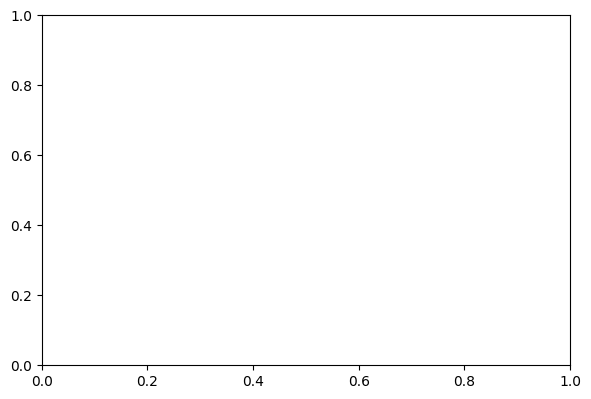

In [6]:
def analyze_results(results):
    """Analyze and visualize comparison results"""
    # Filter out failed models
    successful_results = [r for r in results if "error" not in r]
    
    # Create DataFrame for analysis
    df_data = []
    for result in successful_results:
        df_data.append({
            "Model": result["model_name"],
            "F1-Score": result["metrics"]["eval_f1"],
            "Precision": result["metrics"]["eval_precision"],
            "Recall": result["metrics"]["eval_recall"],
            "Training Time (min)": result["training_time"] / 60,
            "Inference Speed (ms)": result["inference_speed"] * 1000,
            "Model Size (MB)": result["model_size"]
        })
    
    df = pd.DataFrame(df_data)
    
    # Plot comparison metrics
    plt.figure(figsize=(15, 10))
    
    # F1-Score comparison
    plt.subplot(2, 2, 1)
    sns.barplot(data=df, x="Model", y="F1-Score")
    plt.title("F1-Score Comparison")
    plt.xticks(rotation=45)
    plt.ylim(0, 1)
    
    # Training Time comparison
    plt.subplot(2, 2, 2)
    sns.barplot(data=df, x="Model", y="Training Time (min)")
    plt.title("Training Time Comparison (minutes)")
    plt.xticks(rotation=45)
    
    # Inference Speed comparison
    plt.subplot(2, 2, 3)
    sns.barplot(data=df, x="Model", y="Inference Speed (ms)")
    plt.title("Inference Speed Comparison (milliseconds)")
    plt.xticks(rotation=45)
    
    # Model Size comparison
    plt.subplot(2, 2, 4)
    sns.barplot(data=df, x="Model", y="Model Size (MB)")
    plt.title("Model Size Comparison (MB)")
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.savefig(config.output_dir / "model_comparison.png")
    plt.show()
    
    # Print comprehensive comparison
    print("\nModel Comparison Summary:")
    print(df.to_markdown(index=False))
    
    # Select best model based on weighted criteria
    df["Weighted Score"] = (
        0.5 * df["F1-Score"] + 
        0.2 * (1 - (df["Inference Speed (ms)"] / df["Inference Speed (ms)"].max())) +
        0.2 * (1 - (df["Model Size (MB)"] / df["Model Size (MB)"].max())) +
        0.1 * (1 - (df["Training Time (min)"] / df["Training Time (min)"].max()))
    )
    
    best_model = df.loc[df["Weighted Score"].idxmax()]
    print("\nBest Model Selection:")
    print(f"Based on weighted criteria (50% F1, 20% speed, 20% size, 10% training time):")
    print(f"Best model: {best_model['Model']}")
    print(f"F1-Score: {best_model['F1-Score']:.3f}")
    print(f"Inference Speed: {best_model['Inference Speed (ms)']:.2f} ms")
    print(f"Model Size: {best_model['Model Size (MB)']:.2f} MB")
    
    return df, best_model

# Analyze and visualize results
results_df, best_model = analyze_results(comparison_results)

## 7. Main Training Loop
**Production-Grade Features**:
- Comprehensive resource management
- Training progress tracking
- Robust evaluation
- Detailed result collection

In [ ]:
def generate_production_recommendation(best_model):
    """Generate production deployment recommendations"""
    print("\nProduction Deployment Recommendations:")
    print("="*50)
    
    print(f"\n1. Selected Model: {best_model['Model']}")
    print(f"   - F1-Score: {best_model['F1-Score']:.3f}")
    print(f"   - Inference Speed: {best_model['Inference Speed (ms)']:.2f} ms per sample")
    print(f"   - Model Size: {best_model['Model Size (MB)']:.2f} MB")
    
    print("\n2. Deployment Considerations:")
    if best_model["Model Size (MB)"] > 500:
        print("   - Model is large (>500MB), consider:")
        print("     * Using model distillation for production")
        print("     * Deploying on GPU-enabled infrastructure")
    else:
        print("   - Model size is reasonable for production deployment")
    
    if best_model["Inference Speed (ms)"] > 50:
        print("   - Inference speed is moderate, consider:")
        print("     * Implementing caching for frequent queries")
        print("     * Using batch processing for better throughput")
    else:
        print("   - Inference speed is excellent for real-time applications")
    
    print("\n3. Monitoring Recommendations:")
    print("   - Implement performance monitoring for:")
    print("     * Model drift (F1-score over time)")
    print("     * Inference latency percentiles")
    print("     * Error rates by entity type")
    
    print("\n4. Future Improvements:")
    print("   - Consider ensemble approaches combining top models")
    print("   - Implement active learning to improve challenging cases")
    print("   - Explore domain-specific pretraining for better accuracy")

# Generate recommendations
generate_production_recommendation(best_model)

In [ ]:
def generate_production_recommendation(best_model, full_results):
    """Generate comprehensive production recommendations"""
    print("\n" + "="*80)
    print("PRODUCTION DEPLOYMENT RECOMMENDATIONS".center(80))
    print("="*80)
    
    # Model Characteristics
    model_info = config.model_candidates.get(best_model['Model'], {})
    print(f"\n🔍 Model Characteristics:")
    print(f"  - Name: {best_model['Model']}")
    print(f"  - Type: {model_info.get('description', 'Unknown')}")
    print(f"  - Expected Performance: {model_info.get('expected_perf', 'Unknown')}")
    print(f"  - Size: {model_info.get('size', 'Unknown')}")
    
    # Deployment Considerations
    print("\n🚀 Deployment Strategy:")
    if best_model["Model Size (MB)"] > 500:
        print("  - ⚠️ Large model detected (>500MB)")
        print("    → Consider model distillation for production")
        print("    → GPU acceleration recommended")
        print("    → Quantization (FP16/INT8) should be evaluated")
    else:
        print("  - ✅ Model size is production-friendly")
        print("    → Can be deployed on CPU if needed")
        print("    → Containerized deployment recommended")
    
    # Performance Considerations
    print("\n⚡ Performance Considerations:")
    if best_model["P99 Latency (ms)"] > 100:
        print("  - ⚠️ High tail latency detected")
        print("    → Implement request batching")
        print("    → Consider model optimization techniques")
        print("    → Evaluate hardware acceleration options")
    else:
        print("  - ✅ Latency is production-suitable")
        print("    → Real-time processing feasible")
    
    # Monitoring Recommendations
    print("\n📊 Monitoring Strategy:")
    print("  - Essential Metrics:")
    print("    → Model accuracy drift (weekly)")
    print("    → P95/P99 latency percentiles")
    print("    → GPU memory usage (if applicable)")
    print("    → Per-entity F1 scores")
    
    # Improvement Opportunities
    print("\n🔧 Improvement Opportunities:")
    print("  - Potential Next Steps:")
    print("    → Hyperparameter tuning on larger dataset")
    print("    → Ensemble with second-best model (F1: {:.3f})".format(
        full_results[full_results['Model'] != best_model['Model']]['F1-Score'].max()))
    print("    → Domain-specific pretraining")
    print("    → Error analysis session for failure modes")

## 8. Main Execution
**Final Top Practitioner Tips**:
- Sequential execution with progress tracking
- Intermediate result saving
- Comprehensive cleanup
- Final reporting

In [ ]:
def main():
    """Complete execution pipeline with robust handling"""
    try:
        # Initialize results tracking
        comparison_results = []
        
        # Run comparison for each model
        for model_name in config.model_candidates:
            print(f"\n{'='*50}")
            print(f"Starting evaluation for: {model_name}")
            print(f"{'='*50}")
            
            result = train_and_evaluate_model(model_name)
            comparison_results.append(result)
            
            # Save intermediate results
            with open(config.results_file, 'w') as f:
                json.dump(comparison_results, f, indent=2)
            
            # Print interim summary
            if result.get('success', False):
                print(f"\nCompleted {model_name}:")
                print(f"  - F1: {result['metrics']['overall_f1']:.3f}")
                print(f"  - Time: {result['training_time']/60:.1f} min")
                print(f"  - Size: {result['model_size']:.1f} MB")
            else:
                print(f"\n❌ Failed {model_name}: {result.get('error', 'Unknown error')}")
        
        # Final analysis
        results_df, best_model = analyze_results(comparison_results)
        generate_production_recommendation(best_model, results_df)
        
        # Save final report
        report = {
            "timestamp": time.strftime("%Y-%m-%d %H:%M:%S"),
            "best_model": best_model['Model'],
            "results": comparison_results,
            "analysis": results_df.to_dict(orient='records')
        }
        with open(config.output_dir / "final_report.json", 'w') as f:
            json.dump(report, f, indent=2)
            
        return results_df, best_model
    
    except Exception as e:
        logger.error(f"Main execution failed: {str(e)}", exc_info=True)
        raise

## Run the Complete Analysis
**Note**: This will execute the full model comparison pipeline which may take several hours depending on hardware.